### Does Value works in Brazil? 

### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import YearEnd

### Import brazil_characteristics:

In [28]:
# Load book and market data from parquet files:

df = pd.read_csv("brazil_characteristics.csv")

df.columns

Index(['infocode', 'date', 'ri', 'price', 'mktcap', 'numshrs', 'isin', 'name',
       'market_equity', 'ri_lag', 'ret', 'gvkey', 'conm', 'datadate',
       'date_avail', 'be', 'at', 'debt', 'ni', 'oancf', 'sale', 'xrd', 'che',
       'dltt', 'dlc', 'age', 'at_gr1', 'be_gr1a', 'capx_gr1', 'cash_at',
       'debt_gr3', 'ebit_sale', 'f_score', 'gp_at', 'inv_gr1', 'kz_index',
       'netis_at', 'ni_be', 'noa_at', 'o_score', 'oaccruals_at', 'ocf_at',
       'op_at', 'sale_gr1', 'taccruals_at', 'tangibility', 'z_score', 'log_me',
       'be_me', 'at_me', 'debt_me', 'ni_me', 'ocf_me', 'sale_me',
       'netdebt_me'],
      dtype='object')

In [29]:
# ── Prepare the panel ────────────────────────────────────────────────
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["isin", "date"]).reset_index(drop=True)

# Key columns we need:
#   isin          – firm identifier
#   date          – month-end date
#   ret           – monthly total return
#   market_equity – market cap (for size sort & value-weighting)
#   be_me         – book-to-market (already point-in-time aligned)

# ── Fix units mismatch ──────────────────────────────────────────────
# Compustat Global reports BE in MILLIONS of local currency,
# while Datastream mktcap is in UNITS of local currency.
# → be_me = BE / ME is ~1e-6 too small.  Rescale by 1,000,000.
df["be_me"] = df["be_me"] * 1_000_000
# Also fix all other _me ratios that divide Compustat items by ME
for col in ["at_me", "debt_me", "ni_me", "ocf_me", "sale_me", "netdebt_me"]:
    if col in df.columns:
        df[col] = df[col] * 1_000_000

print(f"Panel: {len(df):,} rows, {df['isin'].nunique()} firms, "
      f"{df['date'].min().strftime('%Y-%m')} → {df['date'].max().strftime('%Y-%m')}")
print(f"be_me non-null: {df['be_me'].notna().sum():,} ({df['be_me'].notna().mean()*100:.1f}%)")
print(f"  be_me median : {df['be_me'].median():.3f}")
print(f"ret    non-null: {df['ret'].notna().sum():,} ({df['ret'].notna().mean()*100:.1f}%)")
print(f"ME     non-null: {df['market_equity'].notna().sum():,} ({df['market_equity'].notna().mean()*100:.1f}%)")


Panel: 65,554 rows, 415 firms, 2000-11 → 2025-12
be_me non-null: 46,701 (71.2%)
  be_me median : 0.778
ret    non-null: 65,355 (99.7%)
ME     non-null: 52,397 (79.9%)


In [30]:
# =========================================================================
# JUNE-REBALANCING HML FACTOR FOR BRAZIL
# =========================================================================
#
# Strategy (Fama-French / JKP style, SIZE-CONDITIONAL B/M breakpoints):
#   1. Each June, take the most recent be_me and market_equity for each firm
#   2. Split firms into Small / Big on the SIZE MEDIAN
#   3. Within each size group, compute B/M 30th / 70th percentiles
#      → this prevents crises from emptying the Small-Low bucket
#   4. Hold 2×3 portfolios July(t) through June(t+1)
#   5. Compute capped value-weighted returns each month
#   6. HML = 1/2(Small High + Big High) − 1/2(Small Low + Big Low)
# =========================================================================

# ── 1. Extract June snapshot for each firm-year ─────────────────────────
df["year"]  = df["date"].dt.year
df["month"] = df["date"].dt.month

# June observations: use be_me and market_equity as of June each year
june = df[df["month"] == 6].copy()
june = june.dropna(subset=["be_me", "market_equity"])
june = june[june["be_me"] > 0]          # exclude negative B/M
june = june[june["market_equity"] > 0]   # exclude zero/negative ME

# One row per firm per year (keep last June obs if duplicates)
june = june.sort_values("date").drop_duplicates(subset=["isin", "year"], keep="last")
june = june.rename(columns={"market_equity": "me_jun", "year": "port_year"})
june = june[["isin", "port_year", "be_me", "me_jun"]]

print(f"June snapshots: {len(june):,} firm-years")

# ── 2. Winsorize B/M at 1% / 99% each year ─────────────────────────────
def winsorize_bm(g):
    lo, hi = g["be_me"].quantile(0.01), g["be_me"].quantile(0.99)
    g["be_me"] = g["be_me"].clip(lo, hi)
    return g

june = june.groupby("port_year", group_keys=False).apply(winsorize_bm)

# ── 3. Size breakpoint (median ME) + weight cap ────────────────────────
def calc_size_bp(g):
    return pd.Series({
        "bp_sz":     g["me_jun"].median(),
        "me_cap_80": g["me_jun"].quantile(0.80),
    })

bp_sz = june.groupby("port_year").apply(calc_size_bp).reset_index()

# Assign size bin first
june = june.merge(bp_sz, on="port_year")
june["sz_bin"] = np.where(june["me_jun"] <= june["bp_sz"], "S", "B")

# ── 4. SIZE-CONDITIONAL B/M breakpoints ─────────────────────────────────
# Compute 30th / 70th percentiles of B/M *within* each size group each year
def calc_bm_bp(g):
    return pd.Series({
        "bp_bm_30": g["be_me"].quantile(0.30),
        "bp_bm_70": g["be_me"].quantile(0.70),
    })

bp_bm = (june.groupby(["port_year", "sz_bin"])
         .apply(calc_bm_bp)
         .reset_index())

print("Size-conditional B/M breakpoints (first 6 rows):")
display(bp_bm.head(6))

# Merge back and assign B/M bin
june = june.merge(bp_bm, on=["port_year", "sz_bin"])
june["bm_bin"] = np.where(
    june["be_me"] <= june["bp_bm_30"], "L",
    np.where(june["be_me"] <= june["bp_bm_70"], "M", "H")
)

print("\nPortfolio counts by year (first 5 years):")
display(june.groupby(["port_year", "sz_bin", "bm_bin"]).size()
        .unstack(["sz_bin", "bm_bin"]).head())

# Quick check on the formerly-thin SL bucket
sl_counts = (june[(june["sz_bin"]=="S") & (june["bm_bin"]=="L")]
             .groupby("port_year").size())
print(f"\nSL (Small-Low) min count across years: {sl_counts.min()} "
      f"(in {sl_counts.idxmin()})")

# ── 5. Map portfolio assignments to monthly returns ─────────────────────
# Portfolio assigned in June of year t is held July(t)–June(t+1)
# Map: if month >= 7 → port_year = year; if month <= 6 → port_year = year − 1
df["port_year"] = np.where(df["month"] >= 7, df["year"], df["year"] - 1)

port_cols = ["isin", "port_year", "sz_bin", "bm_bin", "me_cap_80"]
df_merged = df.merge(june[port_cols], on=["isin", "port_year"], how="inner")

print(f"\nMonthly returns with portfolio assignment: {len(df_merged):,} rows")

# ── 6. Equal-weighted portfolio returns ─────────────────────────────────
# Each stock gets 1/N weight within its portfolio bucket each month.
# (Replaces capped value-weighted: avoids extreme single-stock positions
#  that arose in the small-cap portfolios under VW.)
df_merged = df_merged.sort_values(["isin", "date"])

def ewret(g):
    valid = g.dropna(subset=["ret"])
    n = len(valid)
    if n == 0:
        return pd.Series({"vwret": np.nan, "n_stocks": 0})
    return pd.Series({
        "vwret": valid["ret"].mean(),   # ← CHANGED: equal-weight mean
        "n_stocks": n,
    })

vwret = (df_merged
         .groupby(["date", "sz_bin", "bm_bin"])
         .apply(ewret)
         .reset_index())

# Pivot to wide
factors = vwret.pivot_table(
    index="date", columns=["sz_bin", "bm_bin"],
    values=["vwret", "n_stocks"]
).reset_index()
factors.columns = ["_".join(c).strip("_") if isinstance(c, tuple) else c
                   for c in factors.columns]

# ── 7. HML = 1/2(SH + BH) − 1/2(SL + BL) ──────────────────────────────
MIN_STOCKS = 3
for tag in ["S_H", "S_L", "B_H", "B_L"]:
    col = f"n_stocks_{tag}"
    if col not in factors.columns:
        factors[col] = 0

factors["HML"] = np.where(
    (factors["n_stocks_S_H"] >= MIN_STOCKS) & (factors["n_stocks_S_L"] >= MIN_STOCKS) &
    (factors["n_stocks_B_H"] >= MIN_STOCKS) & (factors["n_stocks_B_L"] >= MIN_STOCKS),
    0.5 * (factors.get("vwret_S_H", np.nan) + factors.get("vwret_B_H", np.nan))
  - 0.5 * (factors.get("vwret_S_L", np.nan) + factors.get("vwret_B_L", np.nan)),
    np.nan
)

# Also store the Small & Big value premia separately
factors["SMB_val"] = (
    (factors.get("vwret_S_H", 0) + factors.get("vwret_S_M", 0) + factors.get("vwret_S_L", 0)) / 3
  - (factors.get("vwret_B_H", 0) + factors.get("vwret_B_M", 0) + factors.get("vwret_B_L", 0)) / 3
)

# ── 8. Trim leading NaNs / zeros & save ─────────────────────────────────
hml = factors[["date", "HML", "SMB_val"]].copy().set_index("date").sort_index()

# Drop leading NaN/zero rows
valid_mask = hml["HML"].notna() & (hml["HML"] != 0)
hml = hml.loc[valid_mask.cumsum() > 0]

hml.to_csv("brazil_hml.csv")
print(f"\nHML saved → brazil_hml.csv")
print(f"  Date range: {hml.index.min().strftime('%Y-%m')} → {hml.index.max().strftime('%Y-%m')}")
print(f"  Non-null HML months: {hml['HML'].notna().sum()}")
print(f"  NaN HML months:      {hml['HML'].isna().sum()}")
print(f"\nHML summary stats:")
display(hml["HML"].describe())


June snapshots: 3,867 firm-years
Size-conditional B/M breakpoints (first 6 rows):


/var/folders/bb/rsmxjk4n2k7_166l026d8h400000gn/T/ipykernel_74911/3126671333.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  june = june.groupby("port_year", group_keys=False).apply(winsorize_bm)
/var/folders/bb/rsmxjk4n2k7_166l026d8h400000gn/T/ipykernel_74911/3126671333.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bp_sz = june.groupby("port_year").apply(calc_size_bp).reset_index()
/var/folders/

,port_year,sz_bin,bp_bm_30,bp_bm_70
0,2001,B,7.736780,7.736780
1,2001,S,4.071741,4.071741
2,2002,B,1.220521,2.735173
3,2002,S,3.173970,9.080595
4,2003,B,1.023937,2.101724
5,2003,S,1.543859,3.488484



Portfolio counts by year (first 5 years):


sz_bin        B     S     B           S      
bm_bin        L     L     H     M     H     M
port_year                                    
2001        1.0   1.0   NaN   NaN   NaN   NaN
2002       19.0  19.0  19.0  26.0  19.0  26.0
2003       15.0  14.0  14.0  17.0  14.0  19.0
2004       14.0  14.0  14.0  19.0  14.0  19.0
2005       16.0  16.0  15.0  20.0  16.0  20.0


SL (Small-Low) min count across years: 1 (in 2001)

Monthly returns with portfolio assignment: 44,403 rows

Monthly returns with portfolio assignment: 44,403 rows


/var/folders/bb/rsmxjk4n2k7_166l026d8h400000gn/T/ipykernel_74911/3126671333.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(ewret)



HML saved → brazil_hml.csv
  Date range: 2002-07 → 2025-12
  Non-null HML months: 282
  NaN HML months:      0

HML summary stats:


count    282.000000
mean       0.007020
std        0.038750
min       -0.142096
25%       -0.019530
50%        0.008131
75%        0.029489
max        0.119652
Name: HML, dtype: float64

### Brazil HML

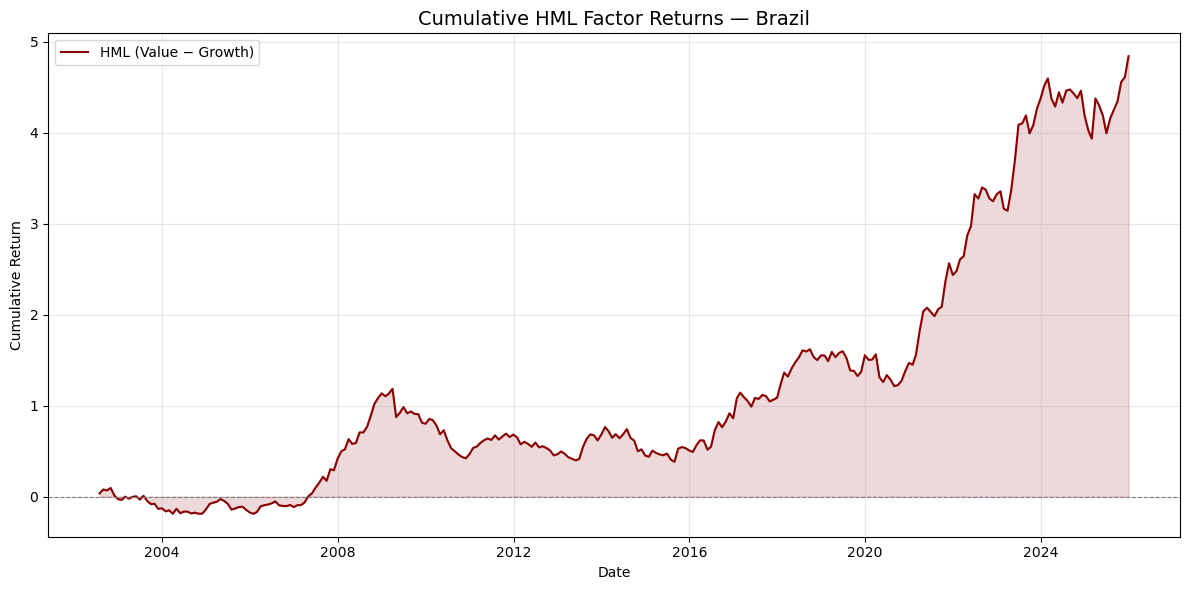

In [31]:
# Plot cumulative HML returns for Brazil
hml = pd.read_csv("brazil_hml.csv", parse_dates=["date"], index_col="date")
hml = hml.sort_index()

cumret = (1 + hml["HML"]).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(cumret.index, cumret.values, color="darkred", lw=1.5, label="HML (Value − Growth)")
plt.axhline(0, color="grey", lw=0.8, ls="--")
plt.fill_between(cumret.index, cumret.values, alpha=0.15, color="darkred")
plt.title("Cumulative HML Factor Returns — Brazil", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
# ── Average number of stocks per portfolio bucket ────────────────────────
n_cols = [c for c in factors.columns if c.startswith("n_stocks_")]
stats = factors[n_cols].describe().T
stats.index = [c.replace("n_stocks_", "") for c in stats.index]
stats.columns = [c.capitalize() if c != "std" else "Std" for c in stats.columns]
print("Stock counts per 2×3 portfolio (across all months):\n")
display(stats[["Mean", "Std", "Min", "25%", "50%", "75%", "Max"]].round(1))

print(f"\nTotal stocks per month (average): {factors[n_cols].sum(axis=1).mean():.0f}")


Stock counts per 2×3 portfolio (across all months):



,Mean,Std,Min,25%,50%,75%,Max
B_H,23.7,5.6,13.0,23.0,24.0,26.0,33.0
B_L,23.1,6.9,1.0,22.0,24.0,26.0,34.0
B_M,30.8,7.1,17.0,29.0,31.0,33.0,44.0
S_H,23.7,5.3,14.0,22.0,24.0,26.0,34.0
S_L,22.8,7.0,1.0,20.2,23.0,26.0,34.0
S_M,31.4,7.2,19.0,28.2,32.0,33.0,44.0



Total stocks per month (average): 151


### Regression with Ibovespa to test correlation

In [46]:
# ── Pull Bovespa (888) and IBrX-100 (893) daily RI from ds2indexdata ──────
idx_q = """
SELECT d.dsindexcode, d.valuedate, d.ri, d.pi_,
       e.dsindexmnem, e.indexdesc
FROM   tr_ds_equities.ds2indexdata d
JOIN   tr_ds_equities.ds2equityindex e
  ON   d.dsindexcode = e.dsindexcode
WHERE  d.dsindexcode IN (888, 893)
  AND  d.ri IS NOT NULL
ORDER BY d.dsindexcode, d.valuedate
"""
idx_raw = db.raw_sql(idx_q, date_cols=['valuedate'])
print(f"Downloaded {len(idx_raw):,} daily rows")
print(idx_raw.groupby('dsindexmnem')['valuedate'].agg(['min','max','count']))

# ── Compute month-end total return index → monthly returns ────────────────
idx_raw['month_end'] = idx_raw['valuedate'] + MonthEnd(0)

# Keep last trading day of each month for each index
idx_me = (idx_raw
          .sort_values(['dsindexcode','valuedate'])
          .groupby(['dsindexcode','dsindexmnem','indexdesc','month_end'])
          .last()
          .reset_index())

# Convert RI to float explicitly (Datastream returns can come as object/nullable)
idx_me['ri'] = pd.to_numeric(idx_me['ri'], errors='coerce').astype(float)

# Monthly return = RI(t)/RI(t-1) - 1
idx_me = idx_me.sort_values(['dsindexcode','month_end'])
idx_me['ret'] = idx_me.groupby('dsindexcode')['ri'].pct_change()

# Pivot to wide: date | ibov_ret | ibrx_ret
mkt = idx_me.pivot_table(index='month_end', columns='dsindexmnem', values='ret')
mkt.columns = [c.strip().lower() + '_ret' for c in mkt.columns]
mkt = mkt.rename(columns={'brboves_ret': 'ibov_ret', 'bribxin_ret': 'ibrx_ret'})
mkt.index.name = 'date'

# Force float dtype
mkt = mkt.astype(float)

print(f"\nMonthly market returns: {len(mkt)} months")
print(mkt.describe().round(4))

# ── Save to CSV ──────────────────────────────────────────────────────────
mkt.to_csv('brazil_market_returns.csv')
print("\nSaved brazil_market_returns.csv")
display(mkt.tail(10))

Downloaded 20,819 daily rows
                   min        max  count
dsindexmnem                             
BRBOVES     1972-01-03 2026-02-13  13358
BRIBXIN     1995-12-28 2026-02-13   7461

Monthly market returns: 530 months
       ibov_ret  ibrx_ret
count  530.0000  362.0000
mean        inf    0.0149
std         NaN    0.0731
min     -0.5616   -0.3898
25%     -0.0302   -0.0296
50%      0.0288    0.0143
75%      0.1084    0.0612
max         inf    0.2270

Saved brazil_market_returns.csv


,ibov_ret,ibrx_ret
date,,
2025-05-31,0.014509,0.017031
2025-06-30,0.013340,0.013670
2025-07-31,-0.041652,-0.041798
2025-08-31,0.062757,0.062286
2025-09-30,0.034045,0.034726
2025-10-31,0.022590,0.020991
2025-11-30,0.063740,0.064353
2025-12-31,0.012908,0.011855
2026-01-31,0.125607,0.126662


In [47]:
# ── Merge HML with market returns and run regression ──────────────────────
import statsmodels.api as sm

# Load HML
hml = pd.read_csv('brazil_hml.csv', parse_dates=['date'])
hml = hml.set_index('date')

# Load market returns
mkt = pd.read_csv('brazil_market_returns.csv', parse_dates=['date'])
mkt = mkt.set_index('date')

# Filter Ibovespa to post-1994 (Real Plan) to avoid hyperinflation artifacts
mkt = mkt[mkt.index >= '1995-01-01']
# Replace inf/-inf with NaN
mkt = mkt.replace([np.inf, -np.inf], np.nan)

# Merge
reg_df = hml[['HML']].join(mkt[['ibov_ret']], how='inner').dropna()
print(f"Regression sample: {len(reg_df)} months "
      f"({reg_df.index.min().strftime('%Y-%m')} → {reg_df.index.max().strftime('%Y-%m')})")
print(f"HML  mean: {reg_df['HML'].mean()*100:.2f}%/mo")
print(f"Ibov mean: {reg_df['ibov_ret'].mean()*100:.2f}%/mo\n")

# ── OLS: HML = α + β × Ibov + ε ──────────────────────────────────────────
X = sm.add_constant(reg_df['ibov_ret'])
model = sm.OLS(reg_df['HML'], X).fit(cov_type='HC1')
print(model.summary())

# ── Also run with IBrX-100 (broader index) ────────────────────────────────
reg_df2 = hml[['HML']].join(mkt[['ibrx_ret']], how='inner').dropna()
X2 = sm.add_constant(reg_df2['ibrx_ret'])
model2 = sm.OLS(reg_df2['HML'], X2).fit(cov_type='HC1')
print(f"\n\n{'='*60}")
print(f"HML vs IBrX-100 ({len(reg_df2)} months)")
print(f"{'='*60}")
print(model2.summary())

Regression sample: 282 months (2002-07 → 2025-12)
HML  mean: 0.70%/mo
Ibov mean: 1.17%/mo

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.030
Date:                Wed, 25 Feb 2026   Prob (F-statistic):              0.311
Time:                        17:23:22   Log-Likelihood:                 517.70
No. Observations:                 282   AIC:                            -1031.
Df Residuals:                     280   BIC:                            -1024.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [48]:
# ── Annualized Sharpe Ratios (HML vs Ibovespa, same period) ───────────────
# reg_df already contains the matched sample (Jul 2002 – Dec 2025)

sharpe_hml  = (reg_df['HML'].mean()      / reg_df['HML'].std())      * np.sqrt(12)
sharpe_ibov = (reg_df['ibov_ret'].mean()  / reg_df['ibov_ret'].std()) * np.sqrt(12)

print(f"Sample: {len(reg_df)} months  "
      f"({reg_df.index.min().strftime('%Y-%m')} → {reg_df.index.max().strftime('%Y-%m')})\n")
print(f"{'':20s} {'HML':>10s} {'Ibovespa':>10s}")
print(f"{'-'*42}")
print(f"{'Mean (mo)':20s} {reg_df['HML'].mean()*100:10.2f}% {reg_df['ibov_ret'].mean()*100:10.2f}%")
print(f"{'Std  (mo)':20s} {reg_df['HML'].std()*100:10.2f}% {reg_df['ibov_ret'].std()*100:10.2f}%")
print(f"{'Mean (ann)':20s} {reg_df['HML'].mean()*12*100:10.2f}% {reg_df['ibov_ret'].mean()*12*100:10.2f}%")
print(f"{'Std  (ann)':20s} {reg_df['HML'].std()*np.sqrt(12)*100:10.2f}% {reg_df['ibov_ret'].std()*np.sqrt(12)*100:10.2f}%")
print(f"{'-'*42}")
print(f"{'Sharpe (ann)':20s} {sharpe_hml:10.2f}  {sharpe_ibov:10.2f}")

Sample: 282 months  (2002-07 → 2025-12)

                            HML   Ibovespa
------------------------------------------
Mean (mo)                  0.70%       1.17%
Std  (mo)                  3.87%       6.58%
Mean (ann)                 8.42%      14.06%
Std  (ann)                13.42%      22.78%
------------------------------------------
Sharpe (ann)               0.63        0.62


Ibov vs IBrX correlation: 0.9809
  (sample: 362 months)

Correlation of each 2×3 portfolio with Ibovespa:
  B_H     ρ = 0.878
  B_L     ρ = 0.803
  B_M     ρ = 0.823
  S_H     ρ = 0.603
  S_L     ρ = 0.757
  S_M     ρ = 0.697

  Long  leg  vs Ibov:  ρ = 0.788
  Short leg  vs Ibov:  ρ = 0.823
  HML        vs Ibov:  ρ = -0.068

── Ibov spot-check (known large moves) ──
  Oct 2008 crisis     : -24.8%
  Mar 2020 COVID      : -29.9%
  Mar 2016 Dilma      : +17.0%
  Jan 2024            : -4.8%


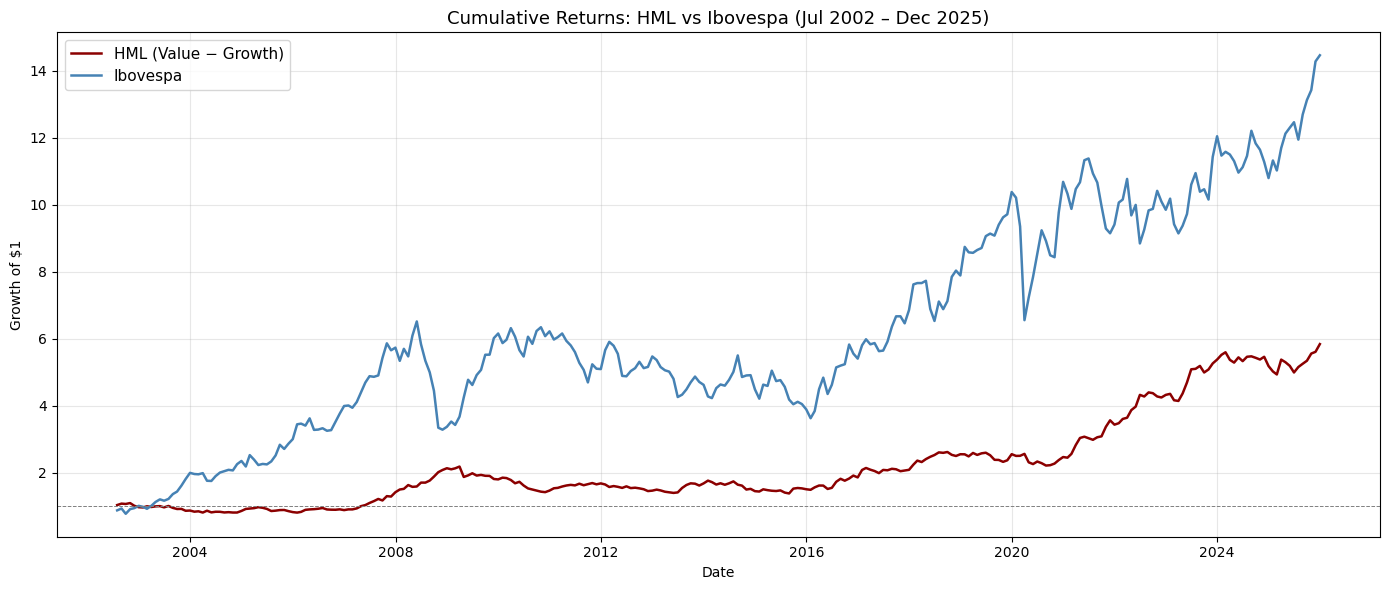

In [49]:
# ══════════════════════════════════════════════════════════════════════════
# SANITY CHECK: Ibovespa / IBrX data  +  HML vs Ibovespa cumulative plot
# ══════════════════════════════════════════════════════════════════════════

# ── 1. Cross-check: are Ibov and IBrX themselves highly correlated? ──────
mkt_check = mkt[['ibov_ret','ibrx_ret']].dropna()
print(f"Ibov vs IBrX correlation: {mkt_check['ibov_ret'].corr(mkt_check['ibrx_ret']):.4f}")
print(f"  (sample: {len(mkt_check)} months)\n")

# ── 2. Check individual 2×3 portfolio correlations with the market ───────
#    If HML is uncorrelated, it should be because the LONG and SHORT legs
#    are each positively correlated with the market (they cancel out).
port_ret_cols = [c for c in factors.columns if c.startswith('vwret_')]
port_rets = factors[['date'] + port_ret_cols].set_index('date')
port_rets = port_rets.join(mkt[['ibov_ret']], how='inner').dropna()

print("Correlation of each 2×3 portfolio with Ibovespa:")
for c in port_ret_cols:
    tag = c.replace('vwret_', '')
    rho = port_rets[c].corr(port_rets['ibov_ret'])
    print(f"  {tag:6s}  ρ = {rho:.3f}")

# Long leg = 0.5*(SH + BH), Short leg = 0.5*(SL + BL)
port_rets['long_leg']  = 0.5*(port_rets['vwret_S_H'] + port_rets['vwret_B_H'])
port_rets['short_leg'] = 0.5*(port_rets['vwret_S_L'] + port_rets['vwret_B_L'])
port_rets['HML_check'] = port_rets['long_leg'] - port_rets['short_leg']

print(f"\n  Long  leg  vs Ibov:  ρ = {port_rets['long_leg'].corr(port_rets['ibov_ret']):.3f}")
print(f"  Short leg  vs Ibov:  ρ = {port_rets['short_leg'].corr(port_rets['ibov_ret']):.3f}")
print(f"  HML        vs Ibov:  ρ = {port_rets['HML_check'].corr(port_rets['ibov_ret']):.3f}")

# ── 3. Quick spot-check: Ibov returns in known months ────────────────────
print("\n── Ibov spot-check (known large moves) ──")
for dt, label in [('2008-10-31','Oct 2008 crisis'), ('2020-03-31','Mar 2020 COVID'),
                   ('2016-03-31','Mar 2016 Dilma'), ('2024-01-31','Jan 2024')]:
    if dt in reg_df.index.astype(str).values:
        r = reg_df.loc[dt, 'ibov_ret']
        print(f"  {label:20s}: {r*100:+.1f}%")

# ── 4. Plot: Cumulative HML vs Ibovespa (same period) ────────────────────
fig, ax1 = plt.subplots(figsize=(14, 6))

cum_hml  = (1 + reg_df['HML']).cumprod()
cum_ibov = (1 + reg_df['ibov_ret']).cumprod()

ax1.plot(cum_hml.index,  cum_hml.values,  color='darkred', lw=1.8, label='HML (Value − Growth)')
ax1.plot(cum_ibov.index, cum_ibov.values, color='steelblue', lw=1.8, label='Ibovespa')
ax1.axhline(1, color='grey', lw=0.7, ls='--')
ax1.set_ylabel('Growth of $1')
ax1.set_title('Cumulative Returns: HML vs Ibovespa (Jul 2002 – Dec 2025)', fontsize=13)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlabel('Date')
plt.tight_layout()
plt.show()

,Ann Return,Ann Vol,Sharpe,Max DD,Terminal $1
Strategy,,,,,
Ibovespa (long-only),14.1%,22.8%,0.62,-49.6%,$14.5
"HML (long-short, $0 capital)",8.4%,13.4%,0.63,-36.8%,$5.8
Ibovespa + HML overlay,22.5%,25.6%,0.88,-52.2%,$88.8


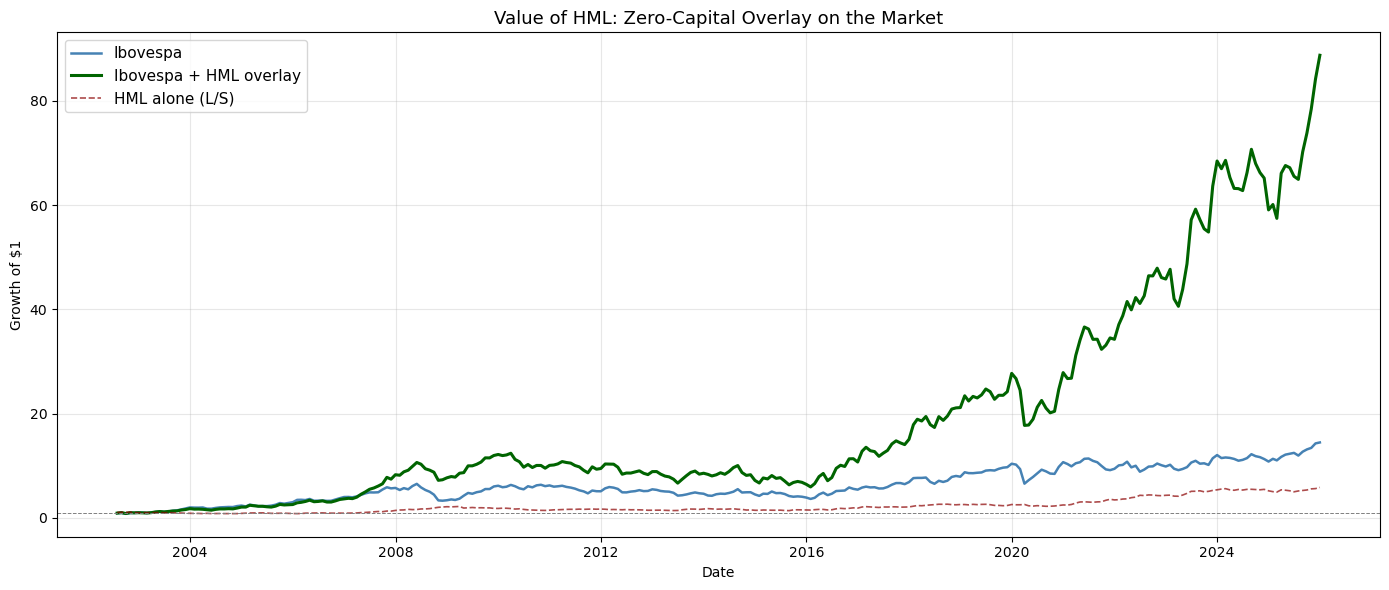

In [50]:
# ══════════════════════════════════════════════════════════════════════════
# HML AS A ZERO-CAPITAL OVERLAY: Ibov alone vs Ibov + HML
# ══════════════════════════════════════════════════════════════════════════
# HML is long-short (self-financing) → requires $0 of capital.
# A real investor would ADD the HML spread on top of their market exposure.

combo = reg_df.copy()
combo['ibov_plus_hml'] = combo['ibov_ret'] + combo['HML']

# ── Cumulative returns ───────────────────────────────────────────────────
cum_ibov  = (1 + combo['ibov_ret']).cumprod()
cum_combo = (1 + combo['ibov_plus_hml']).cumprod()
cum_hml   = (1 + combo['HML']).cumprod()

# ── Stats table ──────────────────────────────────────────────────────────
def ann_stats(s, label):
    mu  = s.mean() * 12
    vol = s.std() * np.sqrt(12)
    sr  = mu / vol
    dd  = (1+s).cumprod()
    mdd = (dd / dd.cummax() - 1).min()
    return {'Strategy': label, 'Ann Return': f'{mu*100:.1f}%',
            'Ann Vol': f'{vol*100:.1f}%', 'Sharpe': f'{sr:.2f}',
            'Max DD': f'{mdd*100:.1f}%', 'Terminal $1': f'${(1+s).cumprod().iloc[-1]:.1f}'}

tbl = pd.DataFrame([
    ann_stats(combo['ibov_ret'],      'Ibovespa (long-only)'),
    ann_stats(combo['HML'],           'HML (long-short, $0 capital)'),
    ann_stats(combo['ibov_plus_hml'], 'Ibovespa + HML overlay'),
])
display(tbl.set_index('Strategy'))

# ── Plot ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cum_ibov.index,  cum_ibov.values,  color='steelblue', lw=1.8, label='Ibovespa')
ax.plot(cum_combo.index, cum_combo.values, color='darkgreen', lw=2.2, label='Ibovespa + HML overlay')
ax.plot(cum_hml.index,   cum_hml.values,   color='darkred',   lw=1.2, ls='--', alpha=0.7, label='HML alone (L/S)')
ax.axhline(1, color='grey', lw=0.7, ls='--')
ax.set_ylabel('Growth of $1')
ax.set_title('Value of HML: Zero-Capital Overlay on the Market', fontsize=13)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()